In [1]:
# Load all the required libraries
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import glob
import os
import cv2
import matplotlib.cm as cm

2023-04-15 22:34:29.966226: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 22:34:30.801254: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## No Mask With Overfitting Control

In [2]:
# save all the hyperparameters in a single place
global_dropout = 0.2
global_lr = 0.001
global_epoch = 30
global_patience = 5

In [3]:
def load_normalize(image_path, normalized=True):
    """Load and normalize image."""
    image = Image.open(image_path).resize([128,128])
    image= np.array(image).astype(np.float32)
    if len(image.shape) == 3:
        image = image.sum(axis=2)
    if normalized:
        return image / 255.0
    else:
        return image
     

In [4]:
# code to load all the data, assuming dataset is at /workspaces/awesome-ml-group/00_source_data/train_relabeled_cleaned
emo_types = ['01_Angry', '02_Disgust', '03_Fear', '04_Happy', '05_Neutral', '06_Sad', '07_Surprise']
emo_inds = np.arange(0, len(emo_types))
x_data = []
y_data = []

# Load the cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/workspaces/awesome-group/00_source_data/train_relabeled_cleaned', emo_types[emo_ind],'*.jpg'))
    x_data += [load_normalize(image_path) for image_path in all_images]
    y_data += [emo_ind]*len(all_images)

(22036, 128, 128, 1) (22036, 7)
(5510, 128, 128, 1) (5510, 7)


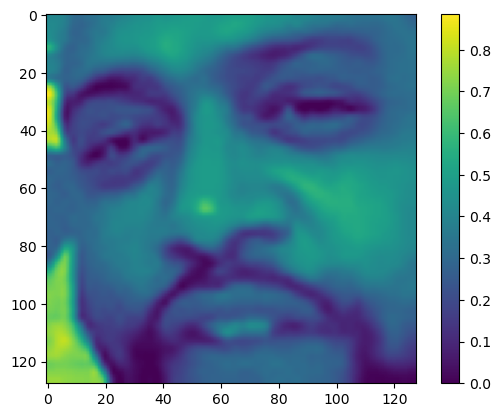

In [5]:
# convert to numpy array

from sklearn.model_selection import StratifiedKFold
# adding a fake color channel
x_data = np.array(x_data).reshape(-1, 128, 128, 1)
y_data = np.array(y_data)

folder = StratifiedKFold(5, shuffle=True)
x_indices = np.arange(0, len(x_data))
train_indices, val_indices = folder.split(x_indices, y_data).__next__()

# shuffling
np.random.shuffle(train_indices)

x_train = x_data[train_indices]
y_train = np.eye(len(emo_types))[y_data[train_indices]]

x_val = x_data[val_indices]
y_val = np.eye(len(emo_types))[y_data[val_indices]]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

plt.imshow(x_train[0,:,:,0])
plt.colorbar()
plt.show()

### Train and fit model

In [6]:
# Train and fit the model
resnet_50_overfit_ctrl = tf.keras.applications.ResNet50(include_top=True, 
                                           weights=None, 
                                           input_tensor=None, 
                                           input_shape=x_train[0].shape, 
                                           pooling=None, 
                                           classes=7)
resnet_50_overfit_ctrl.layers[1].rate = global_dropout
resnet_50_overfit_ctrl.layers[2].trainable = False

# callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = global_patience)

# compile the model
resnet_50_overfit_ctrl.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=global_lr), 
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=tf.keras.metrics.CategoricalAccuracy())

# fit the model using GPU
epochs = global_epoch
history = resnet_50_overfit_ctrl.fit(x_train, 
                        y_train, 
                        validation_data=(x_val, 
                                         y_val), 
                                         epochs=epochs, 
                                         callbacks=[callback])

2023-04-11 23:11:02.687294: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14575 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0


Epoch 1/30


2023-04-11 23:11:23.947227: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-04-11 23:11:34.702593: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-11 23:11:34.703017: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-11 23:11:34.703057: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTERNAL: Couldn't invoke ptxas --version
2023-04-11 23:11:34.703475: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-11 23:11:34.703556: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:317] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This mes

689/689 [==============================] - 70s 53ms/step - loss: 1.7902 - categorical_accuracy: 0.3449 - val_loss: 1.6629 - val_categorical_accuracy: 0.3699
Epoch 2/30
689/689 [==============================] - 34s 49ms/step - loss: 1.4280 - categorical_accuracy: 0.4617 - val_loss: 1.4065 - val_categorical_accuracy: 0.4672
Epoch 3/30
689/689 [==============================] - 34s 49ms/step - loss: 1.4147 - categorical_accuracy: 0.4661 - val_loss: 1.5965 - val_categorical_accuracy: 0.4250
Epoch 4/30
689/689 [==============================] - 34s 49ms/step - loss: 1.2789 - categorical_accuracy: 0.5169 - val_loss: 1.3656 - val_categorical_accuracy: 0.5054
Epoch 5/30
689/689 [==============================] - 34s 49ms/step - loss: 1.1801 - categorical_accuracy: 0.5521 - val_loss: 2.2316 - val_categorical_accuracy: 0.5042
Epoch 6/30
689/689 [==============================] - 34s 49ms/step - loss: 1.1201 - categorical_accuracy: 0.5806 - val_loss: 1.2922 - val_categorical_accuracy: 0.5318
Epo

In [ ]:
# Save the model
resnet_50_overfit_ctrl.save('/workspaces/awesome-group/05_clean_data/resnet_50_overfit_ctrl.h5')

### test saliency

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import glob
import os
import cv2
import matplotlib.cm as cm

2023-04-16 11:02:45.169077: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 11:02:49.122280: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# load the model
resnet_50_overfit_ctrl = tf.keras.models.load_model('/workspaces/awesome-group/05_clean_data/resnet_50_overfit_ctrl.h5')

2023-04-16 11:03:09.363800: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14575 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0


In [4]:
# make a heatmap
last_conv_layer_name = "conv5_block3_out"

def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

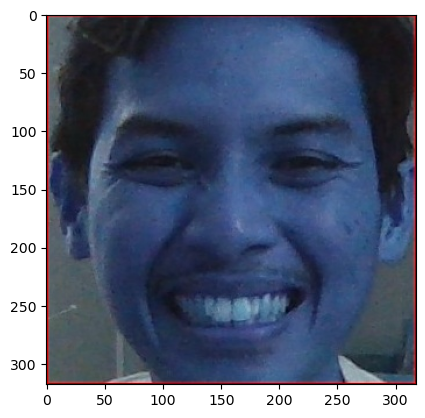

In [7]:
# use face cascade to detect faces
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# detect face from this image
img = cv2.imread('/workspaces/awesome-group/00_source_data/validation_report/w_happy_1.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

# crop the face
for (x,y,w,h) in faces:
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    cv2.imwrite('/workspaces/awesome-group/00_source_data/validation_report/w_happy_1_cl.jpg', roi_color)
    # rewrite the picture to be grayscale
    img = cv2.imread('/workspaces/awesome-group/00_source_data/validation_report/w_happy_1_cl.jpg')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.imwrite('/workspaces/awesome-group/00_source_data/validation_report/w_happy_1_cl.jpg', gray)
    

# plot the result
plt.imshow(img)

1/1 [==============================] - 0s 26ms/step
04_Happy


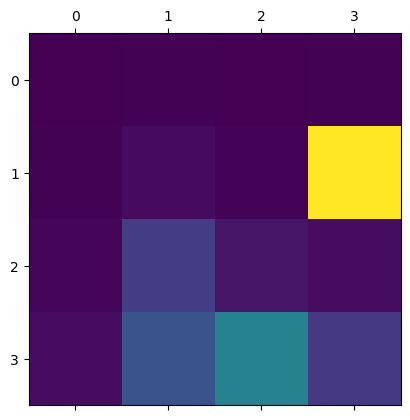

In [8]:
# load image to be predicted
img_path = "/workspaces/awesome-group/00_source_data/validation_report/w_happy_1_cl.jpg"

# Prepare image to have size (-1, 128, 128, 1)
img_array = load_normalize(img_path)
img_array = img_array.reshape(-1, 128, 128, 1)

model = resnet_50_overfit_ctrl

# Remove last layer's activation function
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
# print prediction based on the model emo list
print(emo_types[np.argmax(preds)])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

/tmp/ipykernel_1107/2881501249.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("CMRmap")


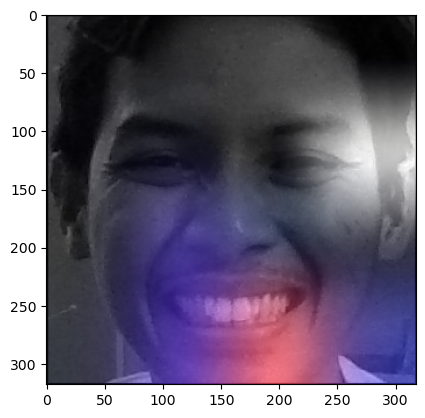

In [9]:
def display_gradcam(img_path, heatmap, alpha=1):
    """Displays the image with the heatmap and original image"""
    # Load the original image
    img = keras.preprocessing.image.load_img(img_path)
    img = keras.preprocessing.image.img_to_array(img)    

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # colorize the using function other than get_cmap
    jet = cm.get_cmap("CMRmap")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    # save the superimposed image as an array
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    # make into an array
    superimposed_img = np.array(superimposed_img)

    # display Grad CAM in 256x256
    return superimposed_img


# Display Grad CAM
plt.imshow(display_gradcam(img_path, heatmap))

### Final Saliency

1/1 [==============================] - 0s 24ms/step


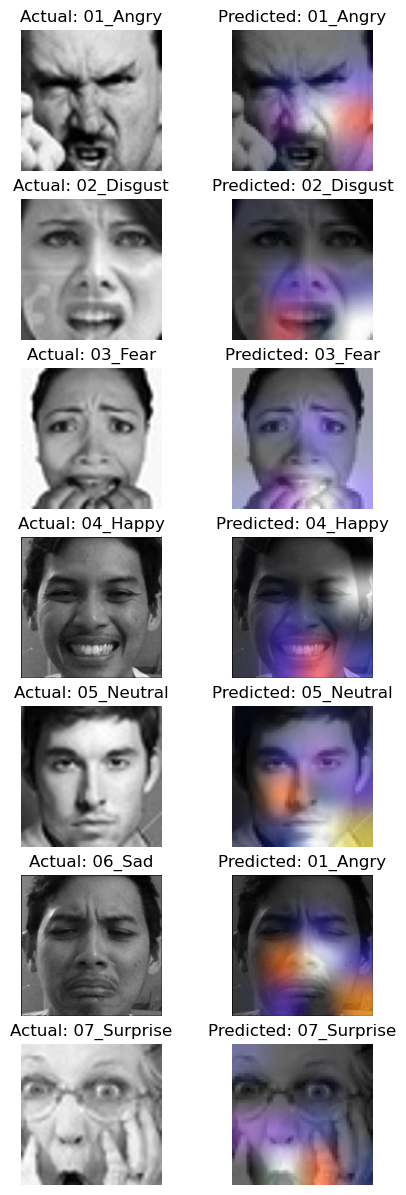

In [10]:
# create a subplot to plot all the images and their respective heatmaps
fig, ax = plt.subplots(7, 2, figsize=(5, 15))

angry = '/workspaces/awesome-group/00_source_data/validation_relabeled_cleaned/01_Angry/3137.jpg'
disgust = '/workspaces/awesome-group/00_source_data/validation_relabeled_cleaned/02_Disgust/533.jpg'
fear = '/workspaces/awesome-group/00_source_data/validation_relabeled_cleaned/03_Fear/4453.jpg'
happy = '/workspaces/awesome-group/00_source_data/validation_report/w_happy_1_cl.jpg'
neutral = '/workspaces/awesome-group/00_source_data/validation_relabeled_cleaned/05_Neutral/1093.jpg'
sad = '/workspaces/awesome-group/00_source_data/validation_report/w_sad_2_cl.jpg'
surprise = '/workspaces/awesome-group/00_source_data/validation_relabeled_cleaned/07_Surprise/6877.jpg'

import warnings
warnings.filterwarnings('ignore')

# Loop through each emotion and create a heatmap for each with the actual label and predicted value above it
for i, emotion in enumerate([angry, disgust, fear, happy, neutral, sad, surprise]):
    # make a subplot with 2 columns and 4 rows
    img_array = load_normalize(emotion)
    img_array = img_array.reshape(-1, 128, 128, 1)
    ax[i, 0].imshow(img_array[0,:,:,0], cmap='gray')
    ax[i, 0].set_title(f"Actual: {emo_types[i]}")
    ax[i, 0].axis('off')
    # make a subplot with 2 columns and 4 rows
    # Prepare image to have size (None, 128, 128, 1)
    model = resnet_50_overfit_ctrl

    # Remove last layer's softmax
    model.layers[-1].activation = None

    # Print what the top predicted class is
    preds = model.predict(img_array)
    # print prediction based on the model emo list
    predx = (emo_types[np.argmax(preds)])

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    ax[i, 1].imshow(img_array[0,:,:,0], cmap='gray')
    ax[i, 1].set_title(f"Predicted: {predx}")
    ax[i, 1].imshow(display_gradcam(emotion, heatmap))
    ax[i, 1].axis('off')

plt.show()


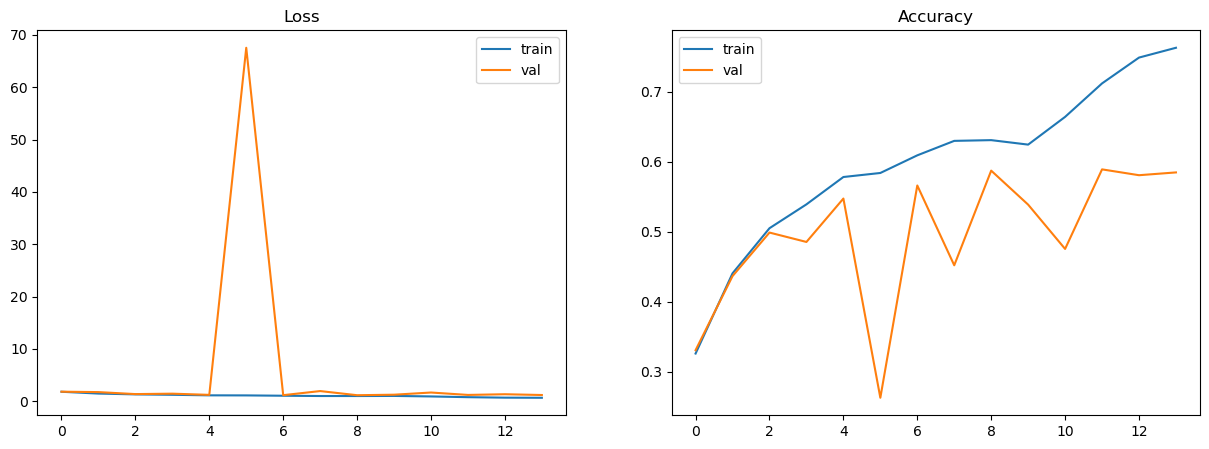

In [7]:
# plot the loss and accuracy in ax[0] and ax[1] respectively
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(history.history['loss'], label='train')
ax[0].plot(history.history['val_loss'], label='val')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(history.history['categorical_accuracy'], label='train')
ax[1].plot(history.history['val_categorical_accuracy'], label='val')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()

In [8]:
# code to load all the data, assuming dataset is at /workspaces/awesome-ml-group/00_source_data/images/train_relabeled_cleaned
x_test = []
y_test = []

# # Load the cascade
# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/workspaces/awesome-group/00_source_data/validation_relabeled_cleaned', emo_types[emo_ind],'*.jpg'))
    # x_data += [load_extract_normalize(image_path) for image_path in all_images]
    x_test += [load_normalize(image_path) for image_path in all_images]
    y_test += [emo_ind]*len(all_images)

# adding a fake color channel
x_test = np.array(x_test).reshape(-1, 128, 128, 1)
y_test = np.array(y_test)
y_test = np.eye(len(emo_types))[y_test]
y_data = np.eye(len(emo_types))[y_data]

In [9]:
# Evaluate the model
loss, acc = resnet_50_overfit_ctrl.evaluate(x_test, y_test, verbose=2)
print("ResNet 50 model, accuracy: {:5.2f}%".format(100 * acc))

203/203 - 3s - loss: 1.2444 - categorical_accuracy: 0.5860 - 3s/epoch - 15ms/step
ResNet 50 model, accuracy: 58.60%


In [10]:
# define the class of the model
from sklearn.metrics import confusion_matrix, classification_report
y_pred = resnet_50_overfit_ctrl.predict(x_test, verbose=2)
y_pred = np.argmax(y_pred,axis = 1)
y_test = np.argmax(y_test,axis = 1)
matrix = confusion_matrix(y_test,y_pred)

203/203 - 3s - 3s/epoch - 17ms/step


In [11]:
# print the confusion matrix
print(classification_report(y_test,y_pred,digits=5))

              precision    recall  f1-score   support

           0    0.58657   0.37387   0.45667       888
           1    0.32258   0.24096   0.27586        83
           2    0.44793   0.29585   0.35634       916
           3    0.80750   0.82363   0.81548      1752
           4    0.49808   0.66046   0.56789      1181
           5    0.45586   0.49357   0.47396      1088
           6    0.57873   0.72241   0.64264       580

    accuracy                        0.58600      6488
   macro avg    0.52818   0.51582   0.51269      6488
weighted avg    0.58455   0.58600   0.57686      6488



In [12]:
matrix.diagonal()/matrix.sum(axis=1)

array([0.37387387, 0.24096386, 0.29585153, 0.82363014, 0.66045724,
       0.49356618, 0.72241379])

In [13]:
# free the GPU memory
tf.keras.backend.clear_session()

# check the GPU memory
!nvidia-smi

# check available memory
!free -h

# Check the GPU VRAM
tf.test.gpu_device_name()

Tue Apr 11 13:51:45 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-16GB            On | 00000001:00:00.0 Off |                  Off |
| N/A   41C    P0               44W / 250W|  15542MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

2023-04-11 13:51:46.682860: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /device:GPU:0 with 14575 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0


'/device:GPU:0'

## No Mask No Overfitting Control

In [14]:
# code to load all the data, assuming dataset is at /workspaces/awesome-ml-group/00_source_data/train_relabeled
emo_types = ['01_Angry', '02_Disgust', '03_Fear', '04_Happy', '05_Neutral', '06_Sad', '07_Surprise']
emo_inds = np.arange(0, len(emo_types))
x_data = []
y_data = []

# Load the cascade
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/workspaces/awesome-group/00_source_data/train_relabeled_cleaned', emo_types[emo_ind],'*.jpg'))
    x_data += [load_normalize(image_path) for image_path in all_images]
    y_data += [emo_ind]*len(all_images)

(22036, 128, 128, 1) (22036, 7)
(5510, 128, 128, 1) (5510, 7)


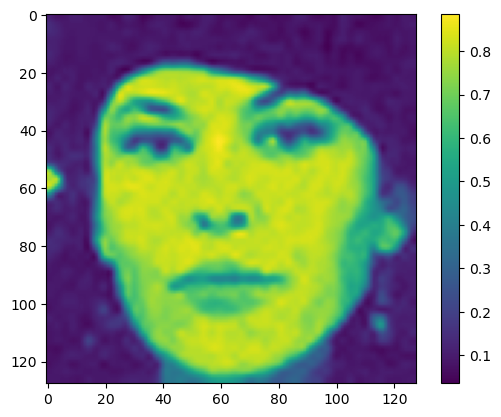

In [15]:
# split the data into train and validation and convert to numpy array

from sklearn.model_selection import StratifiedKFold
# adding a fake color channel
x_data = np.array(x_data).reshape(-1, 128, 128, 1)
y_data = np.array(y_data)

folder = StratifiedKFold(5, shuffle=True)
x_indices = np.arange(0, len(x_data))
train_indices, val_indices = folder.split(x_indices, y_data).__next__()

# shuffling
np.random.shuffle(train_indices)

x_train = x_data[train_indices]
y_train = np.eye(len(emo_types))[y_data[train_indices]]

x_val = x_data[val_indices]
y_val = np.eye(len(emo_types))[y_data[val_indices]]

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

plt.imshow(x_train[0,:,:,0])
plt.colorbar()
plt.show()

In [16]:
# Train and fit the model
resnet_50 = tf.keras.applications.ResNet50(include_top=True, 
                                           weights=None, 
                                           input_tensor=None, 
                                           input_shape=x_train[0].shape, 
                                           pooling=None, 
                                           classes=7)

# callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=global_patience)

# compile the model
resnet_50.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=global_lr), 
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=tf.keras.metrics.CategoricalAccuracy())

# fit the model using GPU
epochs = global_epoch
history = resnet_50.fit(x_train, 
                        y_train, 
                        validation_data=(x_val, 
                                         y_val), 
                                         epochs=epochs, 
                                         callbacks=[callback])

Epoch 1/30
689/689 [==============================] - 40s 50ms/step - loss: 1.7870 - categorical_accuracy: 0.3455 - val_loss: 2.0605 - val_categorical_accuracy: 0.3641
Epoch 2/30
689/689 [==============================] - 34s 49ms/step - loss: 1.4053 - categorical_accuracy: 0.4628 - val_loss: 1.4431 - val_categorical_accuracy: 0.4348
Epoch 3/30
689/689 [==============================] - 34s 49ms/step - loss: 1.2759 - categorical_accuracy: 0.5207 - val_loss: 1.5320 - val_categorical_accuracy: 0.4490
Epoch 4/30
689/689 [==============================] - 34s 49ms/step - loss: 1.1864 - categorical_accuracy: 0.5540 - val_loss: 1.5003 - val_categorical_accuracy: 0.4704
Epoch 5/30
689/689 [==============================] - 34s 49ms/step - loss: 1.1103 - categorical_accuracy: 0.5845 - val_loss: 1.4419 - val_categorical_accuracy: 0.4699
Epoch 6/30
689/689 [==============================] - 34s 49ms/step - loss: 1.0339 - categorical_accuracy: 0.6145 - val_loss: 1.4543 - val_categorical_accuracy:

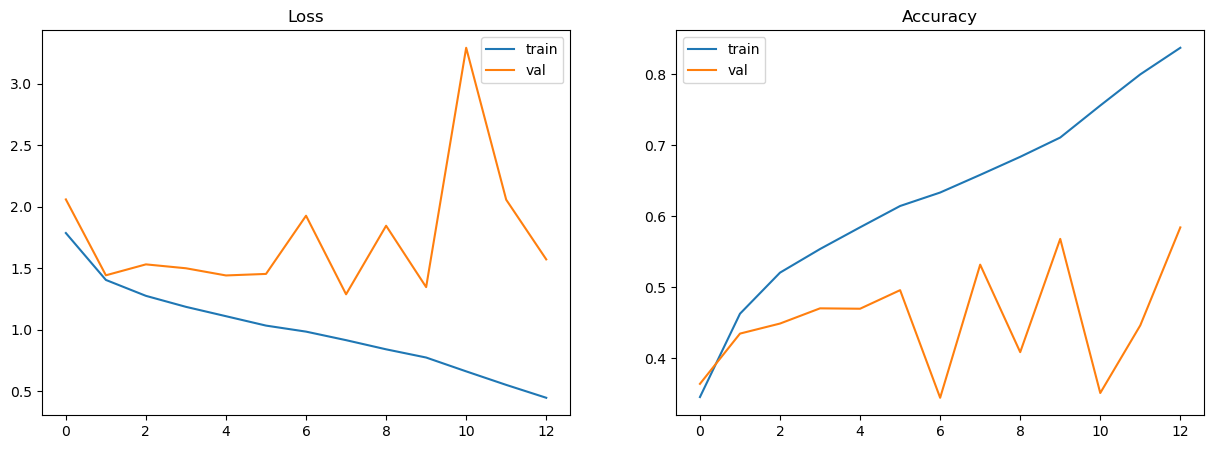

In [17]:
# plot the loss and accuracy in ax[0] and ax[1] respectively
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(history.history['loss'], label='train')
ax[0].plot(history.history['val_loss'], label='val')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(history.history['categorical_accuracy'], label='train')
ax[1].plot(history.history['val_categorical_accuracy'], label='val')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()

In [18]:
# code to load all the data, assuming dataset is at /workspaces/awesome-ml-group/00_source_data/images/train
x_test = []
y_test = []

# # Load the cascade
# face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/workspaces/awesome-group/00_source_data/validation_relabeled_cleaned', emo_types[emo_ind],'*.jpg'))
    # x_data += [load_extract_normalize(image_path) for image_path in all_images]
    x_test += [load_normalize(image_path) for image_path in all_images]
    y_test += [emo_ind]*len(all_images)

# adding a fake color channel
x_test = np.array(x_test).reshape(-1, 128, 128, 1)
y_test = np.array(y_test)
y_test = np.eye(len(emo_types))[y_test]
y_data = np.eye(len(emo_types))[y_data]

In [19]:
# Evaluate the model
loss, acc = resnet_50.evaluate(x_test, y_test, verbose=2)
print("ResNet 50 model, accuracy: {:5.2f}%".format(100 * acc))

203/203 - 3s - loss: 1.7156 - categorical_accuracy: 0.5590 - 3s/epoch - 14ms/step
ResNet 50 model, accuracy: 55.90%


In [20]:
# Predict the test data
from sklearn.metrics import confusion_matrix, classification_report
y_pred = resnet_50.predict(x_test, verbose=2)
y_pred = np.argmax(y_pred,axis = 1)
y_test = np.argmax(y_test,axis = 1)
matrix = confusion_matrix(y_test,y_pred)

203/203 - 4s - 4s/epoch - 20ms/step


In [21]:
print(classification_report(y_test,y_pred,digits=5))

              precision    recall  f1-score   support

           0    0.41463   0.55518   0.47472       888
           1    0.23810   0.42169   0.30435        83
           2    0.47826   0.18013   0.26170       916
           3    0.78853   0.83219   0.80978      1752
           4    0.59809   0.42337   0.49579      1181
           5    0.38778   0.55423   0.45630      1088
           6    0.65785   0.64310   0.65039       580

    accuracy                        0.55903      6488
   macro avg    0.50903   0.51570   0.49329      6488
weighted avg    0.57296   0.55903   0.54939      6488



In [22]:
# display the recall
matrix.diagonal()/matrix.sum(axis=1)

array([0.55518018, 0.42168675, 0.180131  , 0.83219178, 0.42337003,
       0.55422794, 0.64310345])

In [23]:
# free the GPU memory
tf.keras.backend.clear_session()

# check the GPU memory
!nvidia-smi

# check available memory
!free -h

# Check the GPU VRAM
tf.test.gpu_device_name()

Tue Apr 11 14:05:58 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-16GB            On | 00000001:00:00.0 Off |                  Off |
| N/A   29C    P0               35W / 250W|  15542MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

2023-04-11 14:05:59.583750: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /device:GPU:0 with 14575 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0


'/device:GPU:0'

## Forehead Mask

In [25]:
from numpy import load

# code to load the test data
emo_types = ['01_Angry', '02_Disgust', '03_Fear', '04_Happy', '05_Neutral', '06_Sad', '07_Surprise']
emo_inds = np.arange(0, len(emo_types))     

x_test = []
y_test = []

for emo_ind in emo_inds:
    all_images = glob.glob(os.path.join('/workspaces/awesome-group/00_source_data/validation_relabeled_cleaned', emo_types[emo_ind],'*.jpg'))
    x_test += [load_normalize(image_path) for image_path in all_images]
    y_test += [emo_ind]*len(all_images)

# adding a fake color channel
x_test = np.array(x_test).reshape(-1, 128, 128, 1)
y_test = np.array(y_test)
y_test_ohc = np.eye(len(emo_types))[y_test]

def normalization(image):
    return image.astype(np.float32) / 255.0

In [26]:
# load all the forehead mask data
x_data = load('/workspaces/awesome-group/05_clean_data/x_data_forehead_masked.npy')
y_data = load('/workspaces/awesome-group/05_clean_data/y_data_forehead_masked.npy')

x_data = [normalization(img) for img in x_data]

# adding a fake color channel
x_data = np.array(x_data).reshape(-1, 128, 128, 1)
y_data = np.array(y_data)
y_data_ohc = np.eye(len(emo_types))[y_data]

In [27]:
# Train and fit the model
resnet_50 = tf.keras.applications.ResNet50(include_top=True, 
                                           weights=None, 
                                           input_tensor=None, 
                                           input_shape=x_data[0].shape, 
                                           pooling=None, 
                                           classes=7)
resnet_50.layers[1].rate = global_dropout
resnet_50.layers[2].trainable = False

# callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=global_patience)

# compile the model
resnet_50.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=global_lr), 
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=tf.keras.metrics.CategoricalAccuracy())

# fit the model using GPU
epochs = global_epoch
history_forehead = resnet_50.fit(x_data, 
                                 y_data_ohc, 
                                 validation_data=(x_test,
                                                  y_test_ohc),
                                                  epochs=epochs,
                                                  callbacks=[callback])

Epoch 1/30
861/861 [==============================] - 49s 51ms/step - loss: 1.7566 - categorical_accuracy: 0.3590 - val_loss: 1.9150 - val_categorical_accuracy: 0.3477
Epoch 2/30
861/861 [==============================] - 42s 48ms/step - loss: 1.3872 - categorical_accuracy: 0.4744 - val_loss: 1.6500 - val_categorical_accuracy: 0.4010
Epoch 3/30
861/861 [==============================] - 41s 48ms/step - loss: 1.2709 - categorical_accuracy: 0.5182 - val_loss: 1.5283 - val_categorical_accuracy: 0.4319
Epoch 4/30
861/861 [==============================] - 41s 48ms/step - loss: 1.1832 - categorical_accuracy: 0.5506 - val_loss: 1.6358 - val_categorical_accuracy: 0.4743
Epoch 5/30
861/861 [==============================] - 42s 48ms/step - loss: 1.1437 - categorical_accuracy: 0.5704 - val_loss: 1.4431 - val_categorical_accuracy: 0.4656
Epoch 6/30
861/861 [==============================] - 42s 48ms/step - loss: 1.1120 - categorical_accuracy: 0.5811 - val_loss: 2.2718 - val_categorical_accuracy:

In [28]:
# do the prediction
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, classification_report

y_pred = resnet_50.predict(x_test, verbose=2)

y_pred = np.argmax(y_pred,axis = 1)
print(classification_report(y_test,y_pred,digits = 5))
matrix = confusion_matrix(y_test, y_pred)
print(matrix.diagonal()/matrix.sum(axis=1))

203/203 - 3s - 3s/epoch - 17ms/step
              precision    recall  f1-score   support

           0    0.34518   0.53604   0.41994       888
           1    0.35088   0.24096   0.28571        83
           2    0.31347   0.41921   0.35871       916
           3    0.79719   0.80993   0.80351      1752
           4    0.53759   0.48434   0.50958      1181
           5    0.51429   0.23162   0.31939      1088
           6    0.66937   0.56897   0.61510       580

    accuracy                        0.53221      6488
   macro avg    0.50400   0.47015   0.47313      6488
weighted avg    0.55520   0.53221   0.53006      6488

[0.53603604 0.24096386 0.41921397 0.80993151 0.48433531 0.23161765
 0.56896552]


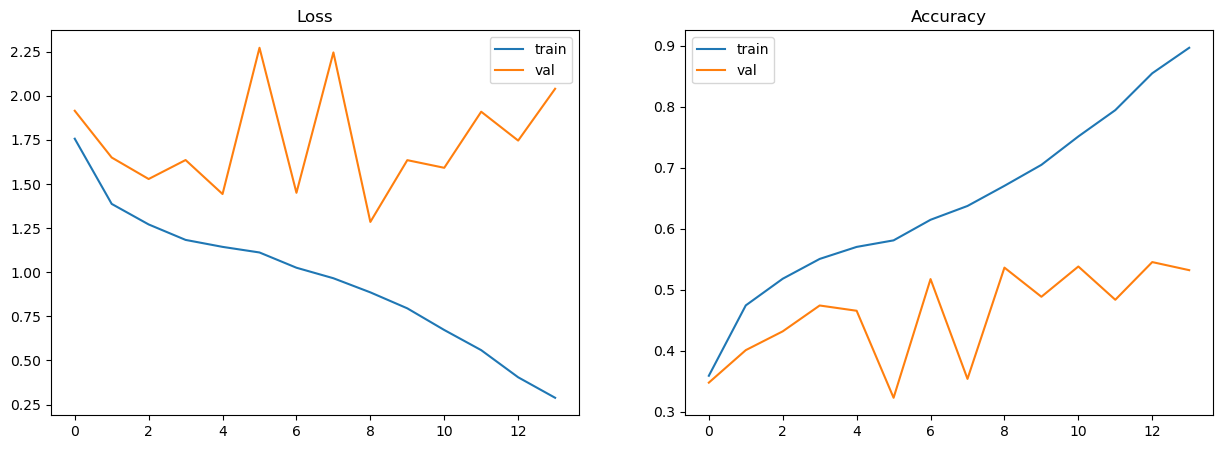

In [29]:
# plot the loss and accuracy in ax[0] and ax[1] respectively
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(history_forehead.history['loss'], label='train')
ax[0].plot(history_forehead.history['val_loss'], label='val')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(history_forehead.history['categorical_accuracy'], label='train')
ax[1].plot(history_forehead.history['val_categorical_accuracy'], label='val')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()

In [30]:
# free the GPU memory
tf.keras.backend.clear_session()

# check the GPU memory
!nvidia-smi

# check available memory
!free -h

# Check the GPU VRAM
tf.test.gpu_device_name()

Tue Apr 11 14:21:58 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-16GB            On | 00000001:00:00.0 Off |                  Off |
| N/A   30C    P0               35W / 250W|  15542MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

2023-04-11 14:21:59.608312: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /device:GPU:0 with 14575 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0


'/device:GPU:0'


## Eyes and Eyebrows

In [31]:
# load the eye and eyebrow mask data
x_data = load('/workspaces/awesome-group/05_clean_data/x_data_eye_eybrow_area_masked.npy')
y_data = load('/workspaces/awesome-group/05_clean_data/y_data_eye_eyebrow_masked.npy')

x_data = [normalization(img) for img in x_data]

# adding a fake color channel
x_data = np.array(x_data).reshape(-1, 128, 128, 1)
y_data = np.array(y_data)
y_data_ohc = np.eye(len(emo_types))[y_data]

In [32]:
# Train and fit the model
resnet_50 = tf.keras.applications.ResNet50(include_top=True, 
                                           weights=None, 
                                           input_tensor=None, 
                                           input_shape=x_data[0].shape, 
                                           pooling=None, 
                                           classes=7)
resnet_50.layers[1].rate = global_dropout
resnet_50.layers[2].trainable = False

# callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=global_patience)

# compile the model
resnet_50.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=global_lr), 
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=tf.keras.metrics.CategoricalAccuracy())

# fit the model using GPU
epochs = global_epoch
history_eyebrow = resnet_50.fit(x_data, 
                                 y_data_ohc, 
                                 validation_data=(x_test,
                                                  y_test_ohc),
                                                  epochs=epochs,
                                                  callbacks=[callback])

Epoch 1/30
861/861 [==============================] - 50s 51ms/step - loss: 1.7311 - categorical_accuracy: 0.3532 - val_loss: 2.1047 - val_categorical_accuracy: 0.3633
Epoch 2/30
861/861 [==============================] - 42s 49ms/step - loss: 1.4439 - categorical_accuracy: 0.4504 - val_loss: 2.3392 - val_categorical_accuracy: 0.2984
Epoch 3/30
861/861 [==============================] - 42s 49ms/step - loss: 1.3393 - categorical_accuracy: 0.4895 - val_loss: 1.6181 - val_categorical_accuracy: 0.3332
Epoch 4/30
861/861 [==============================] - 42s 49ms/step - loss: 1.3127 - categorical_accuracy: 0.5038 - val_loss: 12.9990 - val_categorical_accuracy: 0.2814
Epoch 5/30
861/861 [==============================] - 42s 49ms/step - loss: 1.2690 - categorical_accuracy: 0.5209 - val_loss: 1.4743 - val_categorical_accuracy: 0.4740
Epoch 6/30
861/861 [==============================] - 42s 48ms/step - loss: 1.1919 - categorical_accuracy: 0.5506 - val_loss: 1.4781 - val_categorical_accuracy

In [33]:
# predict the test data
y_pred = resnet_50.predict(x_test, verbose=2)

y_pred = np.argmax(y_pred,axis = 1)
print(classification_report(y_test,y_pred,digits = 5))
matrix = confusion_matrix(y_test, y_pred)
print(matrix.diagonal()/matrix.sum(axis=1))

203/203 - 3s - 3s/epoch - 16ms/step
              precision    recall  f1-score   support

           0    0.38822   0.36374   0.37558       888
           1    0.32836   0.26506   0.29333        83
           2    0.27771   0.50873   0.35929       916
           3    0.77790   0.77968   0.77879      1752
           4    0.50459   0.37257   0.42864      1181
           5    0.39206   0.35386   0.37198      1088
           6    0.72757   0.37759   0.49716       580

    accuracy                        0.49645      6488
   macro avg    0.48520   0.43160   0.44354      6488
weighted avg    0.52924   0.49645   0.50103      6488

[0.36373874 0.26506024 0.50873362 0.77968037 0.37256562 0.35386029
 0.37758621]


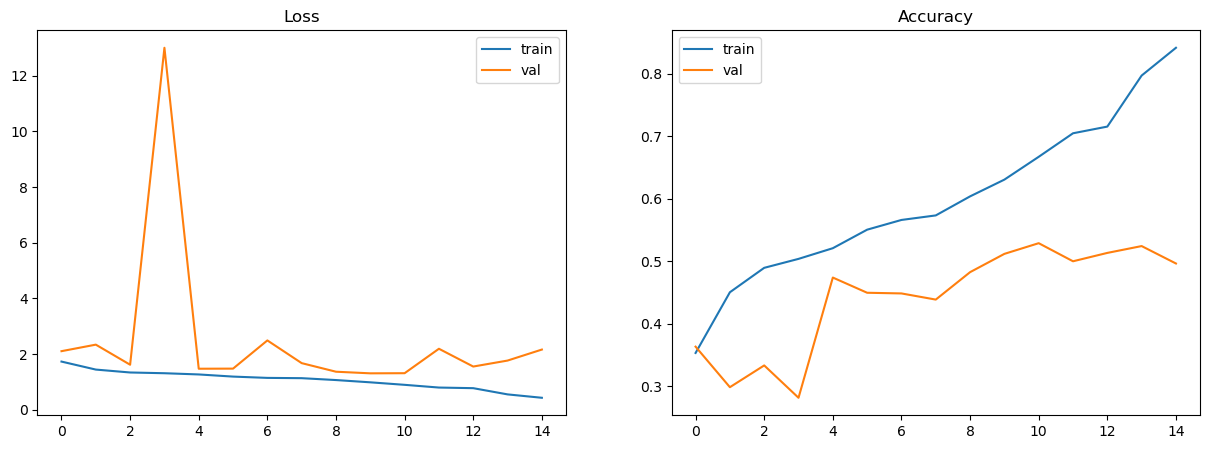

In [34]:
# plot the loss and accuracy in ax[0] and ax[1] respectively
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(history_eyebrow.history['loss'], label='train')
ax[0].plot(history_eyebrow.history['val_loss'], label='val')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(history_eyebrow.history['categorical_accuracy'], label='train')
ax[1].plot(history_eyebrow.history['val_categorical_accuracy'], label='val')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()

In [35]:
# free the GPU memory
tf.keras.backend.clear_session()

# check the GPU memory
!nvidia-smi

# check available memory
!free -h

# Check the GPU VRAM
tf.test.gpu_device_name()

Tue Apr 11 14:34:23 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-16GB            On | 00000001:00:00.0 Off |                  Off |
| N/A   42C    P0               45W / 250W|  15542MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

2023-04-11 14:34:24.865695: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /device:GPU:0 with 14575 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0


'/device:GPU:0'

### Bottom

In [36]:
# load the bottom mask data
x_data = load('/workspaces/awesome-group/05_clean_data/x_data_bottom_masked.npy')
y_data = load('/workspaces/awesome-group/05_clean_data/y_data_bottom_masked.npy')

x_data = [normalization(img) for img in x_data]

# adding a fake color channel
x_data = np.array(x_data).reshape(-1, 128, 128, 1)
y_data = np.array(y_data)
y_data_ohc = np.eye(len(emo_types))[y_data]

In [37]:
# Train and fit the model
resnet_50 = tf.keras.applications.ResNet50(include_top=True, 
                                           weights=None, 
                                           input_tensor=None, 
                                           input_shape=x_data[0].shape, 
                                           pooling=None, 
                                           classes=7)
resnet_50.layers[1].rate = global_dropout
resnet_50.layers[2].trainable = False

# callback
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=global_patience)

# compile the model
resnet_50.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=global_lr), 
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=tf.keras.metrics.CategoricalAccuracy())

# fit the model using GPU
epochs = global_epoch
history_bottom = resnet_50.fit(x_data, 
                                 y_data_ohc, 
                                 validation_data=(x_test,
                                                  y_test_ohc),
                                                  epochs=epochs,
                                                  callbacks=[callback])

Epoch 1/30
861/861 [==============================] - 48s 50ms/step - loss: 1.7892 - categorical_accuracy: 0.3314 - val_loss: 1.8002 - val_categorical_accuracy: 0.1743
Epoch 2/30
861/861 [==============================] - 41s 48ms/step - loss: 1.5576 - categorical_accuracy: 0.4026 - val_loss: 1.7717 - val_categorical_accuracy: 0.2705
Epoch 3/30
861/861 [==============================] - 41s 48ms/step - loss: 1.4445 - categorical_accuracy: 0.4479 - val_loss: 1.6601 - val_categorical_accuracy: 0.2915
Epoch 4/30
861/861 [==============================] - 41s 48ms/step - loss: 1.4252 - categorical_accuracy: 0.4644 - val_loss: 1.5357 - val_categorical_accuracy: 0.3906
Epoch 5/30
861/861 [==============================] - 41s 48ms/step - loss: 1.3617 - categorical_accuracy: 0.4871 - val_loss: 1.7260 - val_categorical_accuracy: 0.3076
Epoch 6/30
861/861 [==============================] - 41s 48ms/step - loss: 1.3199 - categorical_accuracy: 0.5033 - val_loss: 1.7735 - val_categorical_accuracy:

In [38]:
# predict the test data
y_pred = resnet_50.predict(x_test, verbose=2)

y_pred = np.argmax(y_pred,axis = 1)
print(classification_report(y_test,y_pred,digits = 5))
matrix = confusion_matrix(y_test, y_pred)
print(matrix.diagonal()/matrix.sum(axis=1))

203/203 - 3s - 3s/epoch - 16ms/step
              precision    recall  f1-score   support

           0    0.34196   0.41667   0.37563       888
           1    0.12346   0.12048   0.12195        83
           2    0.27801   0.42795   0.33706       916
           3    0.60820   0.24543   0.34974      1752
           4    0.35885   0.44454   0.39713      1181
           5    0.27896   0.38511   0.32355      1088
           6    0.64198   0.26897   0.37910       580

    accuracy                        0.35481      6488
   macro avg    0.37592   0.32988   0.32631      6488
weighted avg    0.42136   0.35481   0.35544      6488

[0.41666667 0.12048193 0.4279476  0.24543379 0.44453853 0.38511029
 0.26896552]


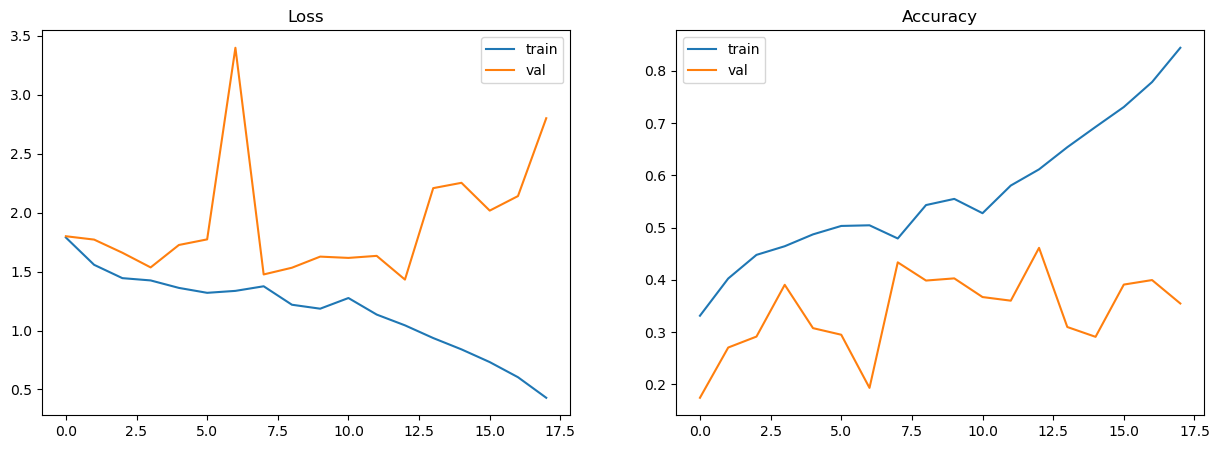

In [39]:
# plot the loss and accuracy in ax[0] and ax[1] respectively
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].plot(history_bottom.history['loss'], label='train')
ax[0].plot(history_bottom.history['val_loss'], label='val')
ax[0].set_title('Loss')
ax[0].legend()
ax[1].plot(history_bottom.history['categorical_accuracy'], label='train')
ax[1].plot(history_bottom.history['val_categorical_accuracy'], label='val')
ax[1].set_title('Accuracy')
ax[1].legend()
plt.show()

In [40]:
# free the GPU memory
tf.keras.backend.clear_session()

# check the GPU memory
!nvidia-smi

# check available memory
!free -h

# Check the GPU VRAM
tf.test.gpu_device_name()

Tue Apr 11 14:47:14 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 530.30.02              Driver Version: 530.30.02    CUDA Version: 12.1     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                  Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf            Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-16GB            On | 00000001:00:00.0 Off |                  Off |
| N/A   42C    P0               44W / 250W|  15542MiB / 16384MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

2023-04-11 14:47:15.687953: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /device:GPU:0 with 14575 MB memory:  -> device: 0, name: Tesla V100-PCIE-16GB, pci bus id: 0001:00:00.0, compute capability: 7.0


'/device:GPU:0'